In [1]:
import pandas as pd

ddata = pd.read_csv("./data/ddata.txt", encoding="euc-kr", sep="\t", names=["num","speaker","contents","tags"])
mdata = pd.read_csv("./data/mdata.txt", encoding="euc-kr", sep="\t", names=["id","part","category","exptype","exp"])

ddata.head()

,num,speaker,contents,tags
0,0,<CO>,어서오세요. 코디봇입니다. 무엇을 도와드릴까요?,INTRO
1,1,<US>,처음 대학교 들어가는데 입을 옷 코디해주세요.,NaN
2,2,<CO>,신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요.,EXP_RES_SITUATION;EXP_RES_DESCRIPTION
3,3,<AC>,SW-009,NaN
4,4,<US>,이 옷에 어울리는 치마로 추천해주세요.,USER_SUCCESS


# 1. 전체 대화셋 개수 카운트

In [2]:
dial_num = 0

for i in range(1, len(ddata)):
    if ddata.loc[i, "num"] == 0:
        dial_num += 1
print("총 대화셋 수: ",dial_num)

총 대화셋 수:  7235


# 2. Mdata 합치기

## - Part 살려서 합치기

In [3]:
c_mdata = pd.DataFrame({"id":[0],"exp":[None]})
c_mdata.drop(0, axis=0, inplace=True)
c_mdata

,id,exp


In [4]:
id = ""
idx = 0
for i in range(len(mdata)):
    if id == mdata.loc[i, "id"]:
        c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] = c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] + " " + mdata.loc[i, "exp"]
    
    else:
        id = mdata.loc[i, "id"]
        c_mdata.loc[i, "id"] = id
        c_mdata.loc[i, "exp"] = mdata.loc[i, "exp"]

c_mdata.head()

,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
20,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
38,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
63,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
84,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


In [5]:
for i in range(len(c_mdata)): # id 뒤에 공백 없애기
    c_mdata.iloc[i].id = c_mdata.iloc[i].id.strip()

print(c_mdata.iloc[0].id)
c_mdata.reset_index(drop=True,inplace=True)
c_mdata.head()

BL-001


,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
1,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
2,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
3,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
4,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


# 3. NaN, Null 값 확인

In [6]:
ddata.drop(ddata.index[ddata.tags == "INTRO"].tolist(), axis=0, inplace=True)
ddata.reset_index(drop=True, inplace=True)
ddata[ddata.tags == "INTRO"]

,num,speaker,contents,tags


In [7]:
ddata.isnull().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [8]:
ddata.isna().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [9]:
ddata.fillna("", inplace=True)
ddata.isna().sum()

num         0
speaker     0
contents    0
tags        0
dtype: int64

In [10]:
mdata.isnull().sum()

id          0
part        0
category    0
exptype     0
exp         0
dtype: int64

In [11]:
c_mdata.isnull().sum()

id     0
exp    0
dtype: int64

# 4. 추천 성공 의상 아이디 종류 및 빈도 카운트 

## 한 번에 추천해도 실패하면 전부 실패로 달기

In [12]:
c_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
c_data.drop(0,axis=0,inplace=True)
c_data.head()

,contents,id


<코드 동작 원리>
<br>

대화문 하나씩 받아온 다음
- AC 태그 문장이면 일단 의상 변수에 저장,
- user_success 태그 문장이면

   - 변수에 저장된 의상이 하나면

      - 바로 대화문 변수랑 의상 변수 및 의상 메타데이터 합쳐서 저장 -> 레이블(id 컬럼에 저장)은 의상 코드가 됨

   - 변수에 저장된 의상의 여러 개면

      - 의상을 하나의 코드 단위로 쪼개서 대화문 변수랑 의상 메타데이터 합쳐서 저장
      
-  둘 다 아니고 일반 대화문이면 대화문 변수에 저장

In [13]:
dial = ddata.loc[0, "contents"].strip()
ac = ""

for i in range(1,len(ddata)):
    cur_sen = ddata.loc[i,"contents"].strip()

    if ddata.loc[i, "num"] > ddata.loc[i-1, "num"]: # 이전 대화셋에 포함된 문장인지 확인
        
        if ddata.loc[i,"speaker"] == "<AC>": # case 1. 의상 아이디가 나온 경우
            if len(ac) > 1:
                ac = ac + " " + cur_sen # 의상 아이디 저장
            else:
                ac = cur_sen

        elif "USER_SUCCESS" == ddata.loc[i,"tags"]: # case 2. USER_SUCCESS 태그가 나온 경우
            if 0 < len(ac) < 7: # 의상을 하나만 추천한 경우
                dial = dial + " " + ac + " " + cur_sen
                c_data.loc[i, "contents"] =  dial + " " + c_mdata.loc[c_mdata.id == ac].exp.values[0]
                c_data.loc[i, "id"] = ac
                ac = ""

            elif len(ac) == 0:
                dial = dial + " " + cur_sen

            else: # 의상을 한 번에 여러 개 추천한 경우
                idx_cnt = 0
                for one_ac in ac.split():
                    c_data.loc[i + idx_cnt, "contents"] =  dial + " " + one_ac + " "+ cur_sen + " " + c_mdata.loc[c_mdata.id == one_ac].exp.values[0]
                    c_data.loc[i + idx_cnt, "id"] = one_ac
                    idx_cnt += 1
                dial = dial + " " + ac + " " + cur_sen    
                ac = ""
        
        elif "USER_FAIL" in ddata.loc[i,"tags"]:
            dial = dial + " " + ac + " " + cur_sen
            ac = ""

        else: # case 3. 그냥 대화문인 경우
            dial = dial + " " + cur_sen
    
    else: #새로운 대화셋 시작이면 초기화
        dial = cur_sen
        ac = ""

In [14]:
print("전체 데이터 수: ", len(c_data))
c_data.head()

전체 데이터 수:  34303


,contents,id
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
12,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
17,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
22,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
26,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [15]:
c_data.reset_index(drop=True ,inplace=True)
c_data.head()

,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
1,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
2,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
4,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [16]:
c_data.loc[0].contents

'처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요. SW-009 이 옷에 어울리는 치마로 추천해주세요. 라운드 네크라인 여밈이 없는 풀오버 스타일 전체 케이블 조직 드롭숄더 슬리브 손등까지 오는 길이의 소매 몸에 적당히 맞는 품 엉덩이를 살짝 덮는 길이 네크라인, 소매 끝, 밑단에 고무단 처리 레이온52%,나일론20%,폴리에스터28% 꽈배기 조직, 플레인 조직이 섞여 있는 형태 드라이 크리닝 단색의 라임색 브라이트톤(고명도 고채도)의 옐로우 그린 산뜻하고 발랄한 느낌 기본의 단정한 편안한 산뜻한 발랄한 경쾌한 따뜻한 데일리룩 캠퍼스룩'

In [17]:
pt_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
pt_data.drop(0,axis=0,inplace=True)
pt_data.head()

,contents,id


In [18]:
for i in range(len(c_data)):
    if "PT" in c_data["id"][i][0:2]:
        pt_data = pt_data.append(c_data.iloc[i])

pt_data.reset_index(drop=True, inplace=True)
print("데이터 개수",len(pt_data))
pt_data.head()

데이터 개수 5568


,contents,id
0,동아리에서 엠티를 가는데 옷이 필요해요. 코디좀 부탁드려요. 활동성 좋은 옷들로 구...,PT-001
1,시험기간에 학교에서 편하게 입을 데일리한 복장 추천해주세요. 무더운 여름날에 시험기...,PT-070
2,친구들과 기차여행 가는데 편하고 활동성 좋은 여행복장 추천해주세요. 고객님께서는 캐...,PT-083
3,남자친구랑 도서관에서 공부하려는데 어울리는 코디보여주세요. 편안함을 주는 실용성 있...,PT-065
4,친구들이랑 둘레길을 걸으려는데 산책하기 좋은 코디 추천해주세요. 편안하고 활동적인 ...,PT-071


In [19]:
pt_data["contents"] = pt_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
pt_data.head()

C:\Users\nipa008\AppData\Local\Temp/ipykernel_3724/3461592690.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  pt_data["contents"] = pt_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,contents,id
0,동아리에서 엠티를 가는데 옷이 필요해요 코디좀 부탁드려요 활동성 좋은 옷들로 구성된...,PT-001
1,시험기간에 학교에서 편하게 입을 데일리한 복장 추천해주세요 무더운 여름날에 시험기간...,PT-070
2,친구들과 기차여행 가는데 편하고 활동성 좋은 여행복장 추천해주세요 고객님께서는 캐주...,PT-083
3,남자친구랑 도서관에서 공부하려는데 어울리는 코디보여주세요 편안함을 주는 실용성 있는...,PT-065
4,친구들이랑 둘레길을 걸으려는데 산책하기 좋은 코디 추천해주세요 편안하고 활동적인 옷...,PT-071


In [20]:
pt_data["id"] = pt_data["id"].str.replace("[^0-9]","")

pt_data.head()

C:\Users\nipa008\AppData\Local\Temp/ipykernel_3724/1211130623.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  pt_data["id"] = pt_data["id"].str.replace("[^0-9]","")


,contents,id
0,동아리에서 엠티를 가는데 옷이 필요해요 코디좀 부탁드려요 활동성 좋은 옷들로 구성된...,001
1,시험기간에 학교에서 편하게 입을 데일리한 복장 추천해주세요 무더운 여름날에 시험기간...,070
2,친구들과 기차여행 가는데 편하고 활동성 좋은 여행복장 추천해주세요 고객님께서는 캐주...,083
3,남자친구랑 도서관에서 공부하려는데 어울리는 코디보여주세요 편안함을 주는 실용성 있는...,065
4,친구들이랑 둘레길을 걸으려는데 산책하기 좋은 코디 추천해주세요 편안하고 활동적인 옷...,071


In [21]:
from collections import Counter
temp = pt_data["id"].tolist()
type_count = dict(Counter(temp))
type_count

{'001': 173,
 '070': 13,
 '083': 23,
 '065': 29,
 '071': 44,
 '068': 42,
 '090': 36,
 '038': 80,
 '066': 52,
 '013': 37,
 '042': 111,
 '059': 27,
 '046': 103,
 '016': 185,
 '003': 17,
 '029': 78,
 '078': 31,
 '044': 96,
 '041': 53,
 '023': 186,
 '035': 39,
 '034': 39,
 '039': 60,
 '040': 33,
 '027': 60,
 '005': 55,
 '025': 25,
 '067': 24,
 '020': 22,
 '081': 20,
 '082': 38,
 '088': 13,
 '009': 13,
 '036': 58,
 '018': 88,
 '006': 98,
 '084': 1,
 '007': 22,
 '043': 31,
 '012': 46,
 '061': 32,
 '011': 38,
 '028': 31,
 '050': 8,
 '057': 5,
 '063': 7,
 '089': 5,
 '010': 29,
 '055': 17,
 '049': 15,
 '072': 40,
 '047': 19,
 '004': 18,
 '026': 17,
 '022': 29,
 '053': 4,
 '085': 14,
 '062': 9,
 '052': 11,
 '008': 1,
 '019': 34,
 '037': 41,
 '032': 2,
 '002': 74,
 '080': 5,
 '031': 22,
 '091': 14,
 '015': 19,
 '060': 33,
 '058': 4,
 '017': 49,
 '033': 6,
 '014': 7,
 '069': 2,
 '024': 6,
 '077': 10,
 '051': 16,
 '087': 15,
 '045': 7,
 '079': 2,
 '056': 4,
 '064': 6,
 '048': 5,
 '030': 9,
 '076': 

In [22]:
len(type_count)

228

In [23]:
del_list = []
for i in type_count.keys():
    if type_count.get(i) == 1:
        del_list.append(i)
del_list

['084', '008', '021', '120', '097', '144', '212', '075', '054', '132']

In [24]:
pt_data.head()

,contents,id
0,동아리에서 엠티를 가는데 옷이 필요해요 코디좀 부탁드려요 활동성 좋은 옷들로 구성된...,001
1,시험기간에 학교에서 편하게 입을 데일리한 복장 추천해주세요 무더운 여름날에 시험기간...,070
2,친구들과 기차여행 가는데 편하고 활동성 좋은 여행복장 추천해주세요 고객님께서는 캐주...,083
3,남자친구랑 도서관에서 공부하려는데 어울리는 코디보여주세요 편안함을 주는 실용성 있는...,065
4,친구들이랑 둘레길을 걸으려는데 산책하기 좋은 코디 추천해주세요 편안하고 활동적인 옷...,071


In [25]:
for i in del_list:
    pt_data = pt_data[pt_data["id"] != i]

In [26]:
len(pt_data)

5558

In [27]:
pt_data.reset_index(drop=True, inplace=True)

<BarContainer object of 218 artists>

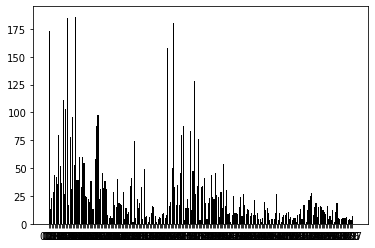

In [28]:
import matplotlib.pyplot as plt
plt.bar(Counter(pt_data.id).keys(),Counter(pt_data.id).values(), color='k')

# 5. 형태소 분석

## Mecab 사용

In [29]:
from eunjeon import Mecab
mecab = Mecab()

In [30]:
mecab.morphs(pt_data["contents"][0])

['동아리',
 '에서',
 '엠티',
 '를',
 '가',
 '는데',
 '옷',
 '이',
 '필요',
 '해요',
 '코디',
 '좀',
 '부탁',
 '드려요',
 '활동',
 '성',
 '좋',
 '은',
 '옷',
 '들',
 '로',
 '구성',
 '된',
 '코디',
 '입니다',
 'CT',
 '060',
 'KN',
 '090',
 'PT',
 '033',
 'SE',
 '032',
 '바지',
 '가',
 '맘',
 '에',
 '들',
 '지',
 '않',
 '아요',
 '바지',
 '바꿔',
 '주',
 '세요',
 '원',
 '하',
 '는',
 '색상',
 '이나',
 '스타일',
 '이',
 '있',
 '으신',
 '가요',
 '어두운',
 '계열',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '엠티',
 '에',
 '가',
 '면',
 '활동',
 '적',
 '으로',
 '움직일',
 '상황',
 '이',
 '많',
 '을',
 '것',
 '같',
 '아서',
 '추천',
 '해',
 '드려요',
 'PT',
 '042',
 '외투',
 '가',
 '어울리',
 '지',
 '않',
 '네요',
 '외투',
 '바꿔',
 '주',
 '세요',
 '편안',
 '한',
 '캐',
 '쥬얼',
 '차림',
 '을',
 '연출',
 '할',
 '수',
 '있',
 '는',
 '항공',
 '점퍼',
 '입니다',
 'JP',
 '031',
 '바지',
 '를',
 '바꿔',
 '주',
 '세요',
 '너무',
 '후줄근',
 '해',
 '보여요',
 '좀',
 '더',
 '단정',
 '한',
 '스타일',
 '을',
 '원하',
 '시',
 '는',
 '건가요',
 '네',
 '청바지',
 '로',
 '추천',
 '해',
 '주',
 '시',
 '겠',
 '어요',
 '마른',
 '체형',
 '이',
 '시',
 '니',
 '피팅',
 '감',
 '좋',
 '은',
 '스키니',
 '진',
 '을',
 '추천',
 '해',
 

In [31]:
len(pt_data)

5558

In [32]:
x_data = []
for i in range(len(pt_data)):
    x_data.append(mecab.morphs(pt_data["contents"][i]))

x_data[0]

['동아리',
 '에서',
 '엠티',
 '를',
 '가',
 '는데',
 '옷',
 '이',
 '필요',
 '해요',
 '코디',
 '좀',
 '부탁',
 '드려요',
 '활동',
 '성',
 '좋',
 '은',
 '옷',
 '들',
 '로',
 '구성',
 '된',
 '코디',
 '입니다',
 'CT',
 '060',
 'KN',
 '090',
 'PT',
 '033',
 'SE',
 '032',
 '바지',
 '가',
 '맘',
 '에',
 '들',
 '지',
 '않',
 '아요',
 '바지',
 '바꿔',
 '주',
 '세요',
 '원',
 '하',
 '는',
 '색상',
 '이나',
 '스타일',
 '이',
 '있',
 '으신',
 '가요',
 '어두운',
 '계열',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '엠티',
 '에',
 '가',
 '면',
 '활동',
 '적',
 '으로',
 '움직일',
 '상황',
 '이',
 '많',
 '을',
 '것',
 '같',
 '아서',
 '추천',
 '해',
 '드려요',
 'PT',
 '042',
 '외투',
 '가',
 '어울리',
 '지',
 '않',
 '네요',
 '외투',
 '바꿔',
 '주',
 '세요',
 '편안',
 '한',
 '캐',
 '쥬얼',
 '차림',
 '을',
 '연출',
 '할',
 '수',
 '있',
 '는',
 '항공',
 '점퍼',
 '입니다',
 'JP',
 '031',
 '바지',
 '를',
 '바꿔',
 '주',
 '세요',
 '너무',
 '후줄근',
 '해',
 '보여요',
 '좀',
 '더',
 '단정',
 '한',
 '스타일',
 '을',
 '원하',
 '시',
 '는',
 '건가요',
 '네',
 '청바지',
 '로',
 '추천',
 '해',
 '주',
 '시',
 '겠',
 '어요',
 '마른',
 '체형',
 '이',
 '시',
 '니',
 '피팅',
 '감',
 '좋',
 '은',
 '스키니',
 '진',
 '을',
 '추천',
 '해',
 

In [33]:
stopwords = []
with open('./data/불용어사전.txt', mode='rt', encoding='utf-8') as f:
    for word in f.readlines():
        word = word.strip()
        stopwords.append(word)
stopwords[0:2]

['어찌됐든', '그위에']

In [34]:
X_data = []
for sentence in x_data: #문장 하나 가져오고 단어 단위로 쪼개기
    temp_X = [word for word in sentence if not word in stopwords] # 불용어 제거
    X_data.append(temp_X)
X_data[0]

['동아리',
 '엠티',
 '는데',
 '옷',
 '필요',
 '코디',
 '부탁',
 '드려요',
 '활동',
 '성',
 '좋',
 '옷',
 '구성',
 '된',
 '코디',
 '입니다',
 'CT',
 '060',
 'KN',
 '090',
 'PT',
 '033',
 'SE',
 '032',
 '바지',
 '맘',
 '지',
 '않',
 '아요',
 '바지',
 '바꿔',
 '주',
 '세요',
 '원',
 '색상',
 '이나',
 '스타일',
 '있',
 '으신',
 '가요',
 '어두운',
 '계열',
 '추천',
 '주',
 '세요',
 '엠티',
 '면',
 '활동',
 '적',
 '움직일',
 '상황',
 '많',
 '같',
 '아서',
 '추천',
 '드려요',
 'PT',
 '042',
 '외투',
 '어울리',
 '지',
 '않',
 '네요',
 '외투',
 '바꿔',
 '주',
 '세요',
 '편안',
 '캐',
 '쥬얼',
 '차림',
 '연출',
 '수',
 '있',
 '항공',
 '점퍼',
 '입니다',
 'JP',
 '031',
 '바지',
 '바꿔',
 '주',
 '세요',
 '너무',
 '후줄근',
 '보여요',
 '더',
 '단정',
 '스타일',
 '원하',
 '시',
 '건가요',
 '청바지',
 '추천',
 '주',
 '시',
 '겠',
 '어요',
 '마른',
 '체형',
 '시',
 '니',
 '피팅',
 '감',
 '좋',
 '스키니',
 '진',
 '추천',
 '드립니다',
 'PT',
 '001',
 '청바지',
 '외투',
 '어울리',
 '상의',
 '추천',
 '주',
 '세요',
 '발목',
 '롱',
 '팬츠',
 '단추',
 '지퍼',
 '밈',
 '밴드',
 '허리',
 'NOMAL',
 '웨이스트',
 '완전히',
 '피트',
 '되',
 '스키니',
 '진',
 '컷팅',
 '처리',
 '된',
 '밑단',
 '관절',
 '보다',
 '위',
 '커팅',
 '디테일',
 '인해',
 '다리'

## 1. 임베딩 레이어 활용

### 정수 인코딩

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

In [36]:
threshold = 6
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4912
등장 빈도가 5번 이하인 희귀 단어의 수: 2146
단어 집합에서 희귀 단어의 비율: 43.688925081433226
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.4586559327487182


In [37]:
vocab_size = total_cnt - rare_cnt + 1 # tokenizer 함수에 들어 갈 때 영향줘서 1 추가 해야 됨
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2767


케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,

케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에

배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 

### 맨 앞자리는 비어있어야 함 (원 핫 인코딩은 정수 인코딩한 뒤 나오는 정수 값 자리에 1을 넣는 것)

In [38]:
tokenizer = Tokenizer(num_words=vocab_size - 1)
tokenizer.fit_on_texts(X_data)
len(tokenizer.word_index)

4912

In [39]:
X_data = tokenizer.texts_to_sequences(X_data) # 단어에 정수 붙여줄 때 num_word 적용

위에서 num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절

예를 들어서 100이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용

In [40]:
X_data[1]

[1237,
 1766,
 881,
 169,
 55,
 38,
 292,
 838,
 944,
 17,
 1,
 2,
 2640,
 1237,
 1766,
 28,
 55,
 38,
 106,
 5,
 20,
 13,
 9,
 10,
 4,
 58,
 16,
 8,
 25,
 35,
 216,
 708,
 92,
 551,
 7,
 978,
 31,
 434,
 481,
 203,
 543,
 1,
 2,
 10,
 1003,
 17,
 1,
 2,
 126,
 68,
 7,
 992,
 962,
 169,
 43,
 41,
 495,
 43,
 320,
 2107,
 27,
 251,
 270,
 52,
 278,
 19,
 46,
 63,
 62,
 15,
 154,
 376,
 979,
 40,
 19,
 63,
 62,
 254,
 2047,
 170,
 298,
 334,
 88,
 34,
 320,
 103,
 39,
 320,
 45,
 1011,
 593,
 67,
 2108,
 763,
 14,
 223,
 271,
 272,
 79,
 1215,
 90,
 359,
 348,
 194,
 74,
 3,
 852,
 36,
 194,
 163,
 5,
 3,
 24,
 21,
 66,
 74,
 205,
 302,
 28,
 143]

문장 최대 길이 : 438
문장의 평균 길이 : 183.1336811802807


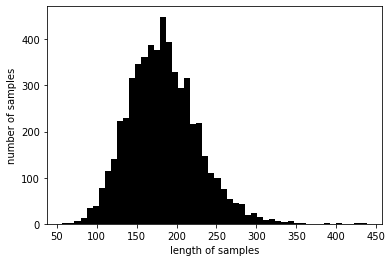

In [41]:
print('문장 최대 길이 :',max(len(l) for l in X_data))
print('문장의 평균 길이 :',sum(map(len, X_data))/len(X_data))
plt.hist([len(s) for s in X_data], bins=50, color='k')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
plt.close()

In [42]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 300
below_threshold_len(max_len, X_data)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 99.04641957538684


## padding

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_data = pad_sequences(X_data, maxlen = max_len)

In [44]:
print(len(X_data[1]))
X_data[1]

300


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# 6. LSTM 돌리기 

In [45]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [46]:
X = X_data
y = pt_data.id.tolist()

In [47]:
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [48]:
y[1]

'070'

In [49]:
print(len(X),len(y))

5558 5558


In [50]:
y = to_categorical(y)

In [51]:
print(X.shape, y.shape)

(5558, 300) (5558, 235)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=777, stratify=y) #추천 한 번밖에 안된 애들 있어서 stratify 안됨

In [53]:
num_class = int(max(pt_data.id)) + 1

In [54]:
from tensorflow.keras.layers import LSTM

In [59]:
model = Sequential()
model.add(Embedding(vocab_size, max_len))
model.add(LSTM(max_len))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         830100    
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 235)               70735     
Total params: 1,622,035
Trainable params: 1,622,035
Non-trainable params: 0
_________________________________________________________________


In [60]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('pt_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [61]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_split=0.2)

print("테스트 셋 체크")
loaded_model = load_model('pt_model_lstm.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 4.1139 - acc: 0.2246
Epoch 00001: val_acc improved from -inf to 0.47686, saving model to pt_model_lstm.h5
98/98 [==============================] - 213s 2s/step - loss: 4.1139 - acc: 0.2246 - val_loss: 2.6302 - val_acc: 0.4769
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 1.6417 - acc: 0.6783
Epoch 00002: val_acc improved from 0.47686 to 0.81491, saving model to pt_model_lstm.h5
98/98 [==============================] - 221s 2s/step - loss: 1.6417 - acc: 0.6783 - val_loss: 0.9018 - val_acc: 0.8149
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.5955 - acc: 0.8811
Epoch 00003: val_acc improved from 0.81491 to 0.94216, saving model to pt_model_lstm.h5
98/98 [==============================] - 185s 2s/step - loss: 0.5955 - acc: 0.8811 - val_loss: 0.3850 - val_acc: 0.9422
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.2430 - acc: 0.9457
Epoch 00004: val_acc im

Cannot convert a symbolic Tensor -> numpy 버전 1.19.5로 바꿔줌

https://wikidocs.net/45101

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


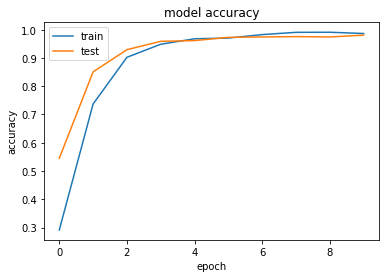

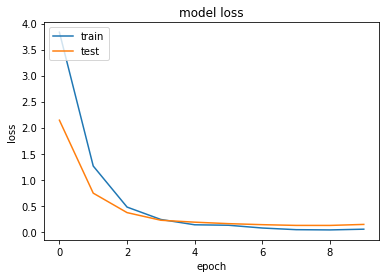

In [58]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()